Here we test the integration of the Hubble parameter $H(z)$ for the GILA model.

In [13]:
#Import libraries related to BAO data.
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import time
import os
import git

from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz as cumtrapz
from scipy.constants import c as c_light #meters/seconds
from scipy.constants import G as G_newton
c_light_km = c_light/1000

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir

Lets define some functions for the calculations of $H(z)$

In [14]:
def E_LCDM(z, Omega_m):
    '''
    Calculation of the normalized Hubble parameter, independent
    of the Hubble constant H0.
    '''
    Omega_lambda = 1 - Omega_m
    E = np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)
    return E

def H_LCDM(z, Omega_m, H_0):
    '''
    Calculation of the Hubble parameter.
    Here we neclect the radiation (it holds 
    that \Omega_r + \Omega_m + \Omega_L = 1).
    '''
    H = H_0 * E_LCDM(z, Omega_m)
    return H


In [15]:
def F_H(H, params):     
    lamb, L, beta, L_bar = params
    FH = H**2 - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10) \
              + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2)
    return FH

def F_H_prime(H, params):
    lamb, L, beta, L_bar = params
    aux = np.exp(-beta*(L_bar*H)**10) * beta * (L_bar*H)**4 * (-3 + 5 * beta * (L_bar*H)**10) +\
          np.exp(lamb*(L*H)**2) * lamb * (L*H)**6 * (4 + lamb*(L*H)**2)
    FH_prime = 2 * H * (1 + aux) 
    return FH_prime

In [16]:
'''

def omega_luisa_to_CDM(beta, L_bar, H0, omega_m_luisa):
    factor = F_H(H0, [0, 1e-27/H0, beta, L_bar/H0]) / H0**2
    omega_cdm = omega_m_luisa * factor
    return omega_cdm

def omega_CDM_to_luisa(beta, L_bar, H0, omega_lcdm):
    factor_inv = H0**2 / F_H(H0, [0, 1e-27/H0, beta, L_bar/H0]) 
    omega_luisa = omega_lcdm * factor_inv
    return omega_luisa
'''

'\n\ndef omega_luisa_to_CDM(beta, L_bar, H0, omega_m_luisa):\n    factor = F_H(H0, [0, 1e-27/H0, beta, L_bar/H0]) / H0**2\n    omega_cdm = omega_m_luisa * factor\n    return omega_cdm\n\ndef omega_CDM_to_luisa(beta, L_bar, H0, omega_lcdm):\n    factor_inv = H0**2 / F_H(H0, [0, 1e-27/H0, beta, L_bar/H0]) \n    omega_luisa = omega_lcdm * factor_inv\n    return omega_luisa\n'

In [17]:
def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'HS'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    


    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, omega_m_0] = params_ode

    omega_r_0 = 2.47e-5
    #omega_r_0 = 4.18e-5 #2.47e-5
    rho_m_0 = 100**2 * omega_m_0 / kappa
    rho_r_0 = 100**2 * omega_r_0 / kappa
    
    a = 1/(1+z)

    rho_r = rho_r_0 * a**(-4)
    rho_m = rho_m_0 * a**(-3)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [lamb, L, b, L_bar]))     
    #print(s)
    return s


def integrator_GILA(physical_params, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, beta, H0, omega_m = physical_params
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    ode_params = [0, 1e-27/H0, beta, L_bar/H0, H0, omega_m]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

# Import the data:

In [18]:
import pandas as pd
from numpy.linalg import inv
# Cosmic Chronometers
def read_data_chronometers(file_chronometers):
    # Read text with data
    z, h, dh = np.loadtxt(file_chronometers, usecols=(0,1,2), unpack=True)
    return z, h, dh

def read_data_pantheon_plus(file_pantheon_plus,file_pantheon_plus_cov):

    '''
    Takes Pantheon+ data and extracts the data from the zhd and zhel 
    redshifts, its error dz, in addition to the data of the apparent magnitude
    with its error: mb and dm. With the errors of the apparent magnitude 
    builds the associated correlation matrix. The function returns the
    information of the redshifts, the apparent magnitude 
    and the correlation matrix inverse.
    '''

    # Read text with data

    data = pd.read_csv(file_pantheon_plus,delim_whitespace=True)
    ww = (data['zHD']>0.01) | (np.array(data['IS_CALIBRATOR'],dtype=bool))

    zhd = data['zHD'][ww]
    zhel = data['zHEL'][ww]
    mb = data['m_b_corr'][ww]

    Ccov=np.load(file_pantheon_plus_cov)['arr_0']
    Cinv=inv(Ccov)

    return zhd, zhel, Cinv, mb


def chi2_supernovae(muth, muobs, C_invertida):
    '''This function estimates the value of the statistic chi squared
    for the Supernovae data.'''
    deltamu = muth - muobs #row vector
    transp = np.transpose(deltamu) #column vector
    aux = np.dot(C_invertida,transp) #column vector
    chi2 = np.dot(deltamu,aux) #scalar
    return chi2

def chi2_sin_cov(teo, data, errors_cuad):
    '''
    Calculate chi square assuming no correlation.

    teo (array): Theoretical prediction of the model.
    data (array): Observational data to compare with the model.
    errors_cuad (array): The square of the errors of the data.

    '''

    chi2 = np.sum((data-teo)**2/errors_cuad)
    return chi2

#%% Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')
[zs_cc, Hs_cc, sigmas_cc] = ds_CC


#%% Pantheon plus
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
zhd, zhel, Cinv, mb = read_data_pantheon_plus('Pantheon+SH0ES.dat',
                        'covmat_pantheon_plus_only.npz')
emu=np.sqrt(np.diag(np.linalg.inv(Cinv)))


Let's define some paraters that will be fixed on the entire analysis

In [19]:
# LCDM parameters
zs_lcdm = np.linspace(0,3,int(1e5))
H_0 = 68

# GILA parameters
L_bar = 0.9 #in units of H0

#Supernovae data
Mabs = -19.37
muobs =  mb - Mabs

# $\omega_m = 0.143$

Given \omega_m=0.143 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 1866.6112961396816
For $\beta$ = 0.1, we have $\chi_2$ = 1743.2508480102877
For $\beta$ = 0.2, we have $\chi_2$ = 1712.8414064878286
For $\beta$ = 0.3, we have $\chi_2$ = 1709.342162625605
For $\beta$ = 0.4, we have $\chi_2$ = 1711.2676660506338
For $\beta$ = 0.5, we have $\chi_2$ = 1717.303728520317
For $\beta$ = 0.6, we have $\chi_2$ = 1731.4471224171236
For $\beta$ = 0.7, we have $\chi_2$ = 1757.2083523489719
For $\beta$ = 0.8, we have $\chi_2$ = 1795.9753129507853


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


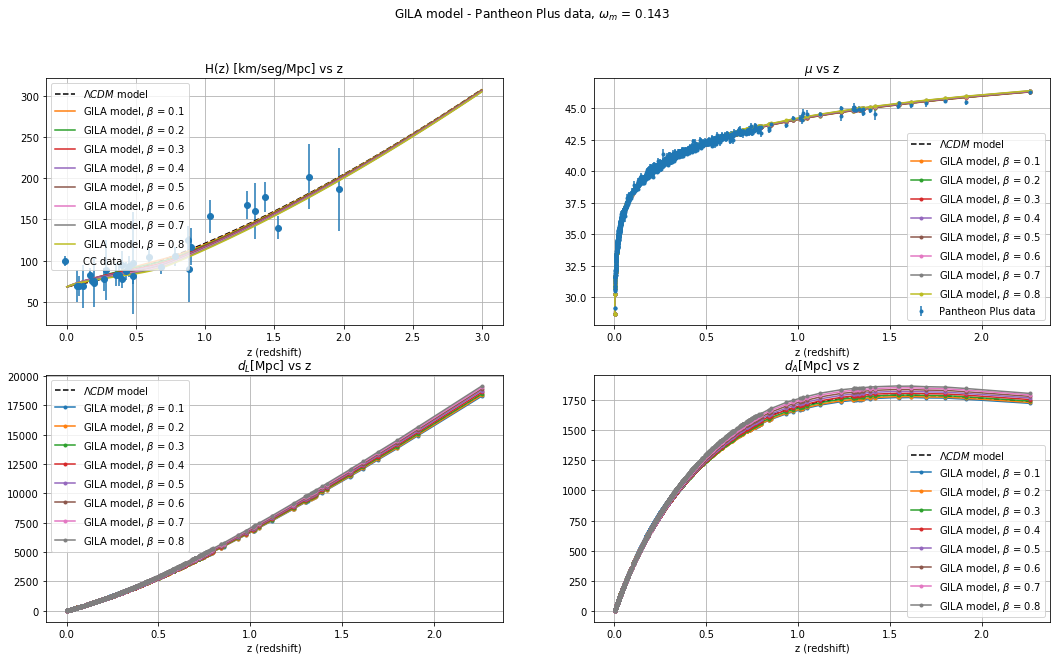

In [20]:
omega_m = 0.143

#LCDM stuff
h = H_0/100
Omega_m = omega_m/h**2

Hs_interpolado = interp1d(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_lcdm, Omega_m, H_0)**(-1), zs_lcdm, initial=0)
int_inv_Hs_interpolado = interp1d(zs_lcdm, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)

fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\omega_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \omega_m=0.143 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

#for beta in([0.1, 1., 6.145, 10, 100]):
#for beta in([1,2,3,4,5,6,7,8,9]):
for beta in([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]):
    physical_params = [L_bar, beta, H_0, omega_m]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

    #axs[0,0].set_xlim(0,0.5)

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()



# $\omega_m = 0.142$

Given \omega_m=0.142 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 1872.183141794993
For $\beta$ = 0.1, we have $\chi_2$ = 1746.0481702718198
For $\beta$ = 0.2, we have $\chi_2$ = 1713.908376527493
For $\beta$ = 0.3, we have $\chi_2$ = 1709.8505677463509
For $\beta$ = 0.4, we have $\chi_2$ = 1711.9680837386675
For $\beta$ = 0.5, we have $\chi_2$ = 1718.5858418857122
For $\beta$ = 0.6, we have $\chi_2$ = 1733.4866201518164
For $\beta$ = 0.7, we have $\chi_2$ = 1760.0593925754754
For $\beta$ = 0.8, we have $\chi_2$ = 1799.6205118906457


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


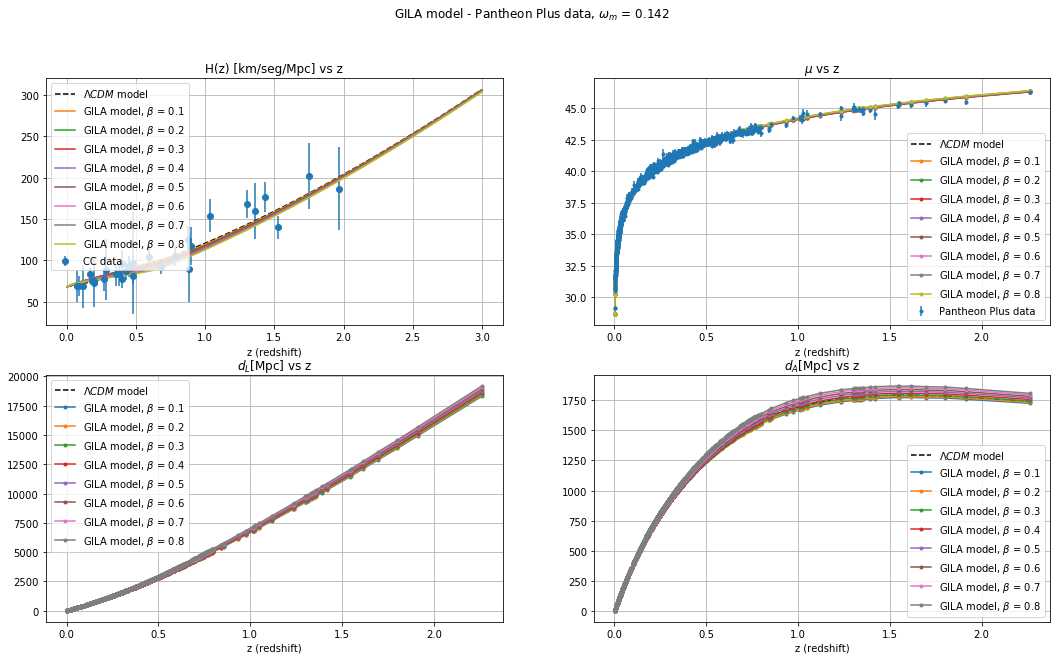

In [21]:
omega_m = 0.142

#LCDM stuff
h = H_0/100
Omega_m = omega_m/h**2

Hs_interpolado = interp1d(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_lcdm, Omega_m, H_0)**(-1), zs_lcdm, initial=0)
int_inv_Hs_interpolado = interp1d(zs_lcdm, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)

fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\omega_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \omega_m=0.142 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

#for beta in([0.1, 1., 6.145, 10, 100]):
#for beta in([1,2,3,4,5,6,7,8,9]):
#for beta in([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3]):
for beta in([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]):
    physical_params = [L_bar, beta, H_0, omega_m]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()


# $\omega_m = 0.144$

Given \omega_m=0.144 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 1861.1618010778773
For $\beta$ = 0.1, we have $\chi_2$ = 1740.592987921988
For $\beta$ = 0.2, we have $\chi_2$ = 1711.9027722077235
For $\beta$ = 0.3, we have $\chi_2$ = 1708.9462604860041
For $\beta$ = 0.4, we have $\chi_2$ = 1710.6674986829619
For $\beta$ = 0.5, we have $\chi_2$ = 1716.1135520003452
For $\beta$ = 0.6, we have $\chi_2$ = 1729.4938597871549
For $\beta$ = 0.7, we have $\chi_2$ = 1754.4393780652688
For $\beta$ = 0.8, we have $\chi_2$ = 1792.4088717816219


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


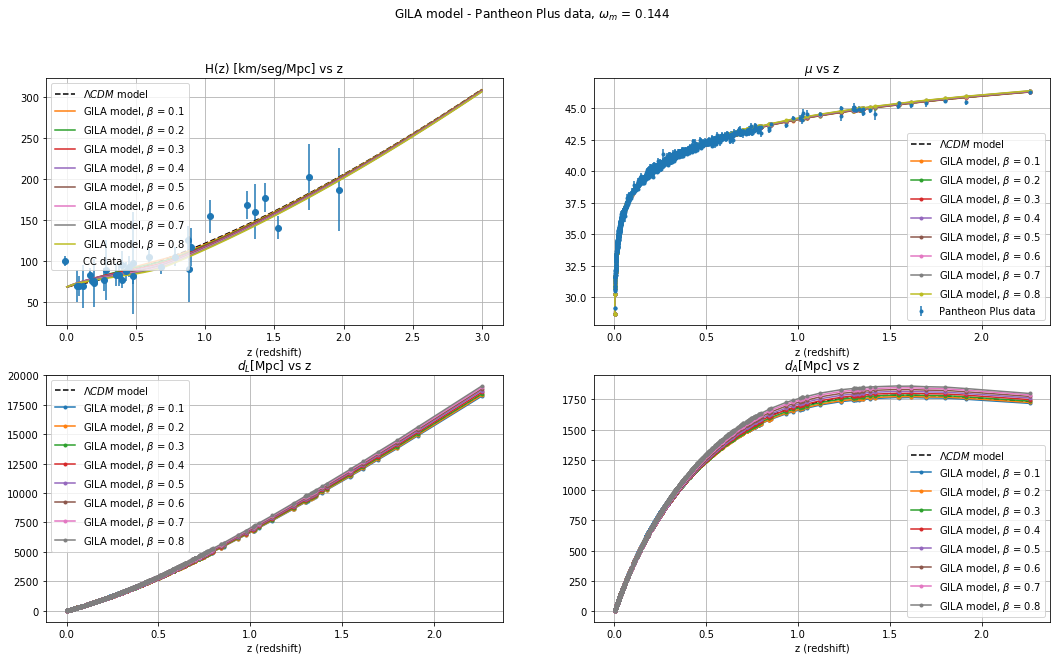

In [22]:
omega_m = 0.144

#LCDM stuff
h = H_0/100
Omega_m = omega_m/h**2

Hs_interpolado = interp1d(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_lcdm, Omega_m, H_0)**(-1), zs_lcdm, initial=0)
int_inv_Hs_interpolado = interp1d(zs_lcdm, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)

fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\omega_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')


axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \omega_m=0.144 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

#for beta in([0.1, 1., 6.145, 10, 100]):
#for beta in([1,2,3,4,5,6,7,8,9]):
for beta in([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]):
#for beta in([0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]):
    physical_params = [L_bar, beta, H_0, omega_m]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()


# $\omega_m = 0.16$

Given \omega_m=0.16 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 1789.9839455253841
For $\beta$ = 0.1, we have $\chi_2$ = 1716.1060962145593
For $\beta$ = 0.2, we have $\chi_2$ = 1713.3189556302834
For $\beta$ = 0.3, we have $\chi_2$ = 1716.9850041907703
For $\beta$ = 0.4, we have $\chi_2$ = 1713.9001603306533
For $\beta$ = 0.5, we have $\chi_2$ = 1708.8819474482104
For $\beta$ = 0.6, we have $\chi_2$ = 1709.3567753243137
For $\beta$ = 0.7, we have $\chi_2$ = 1720.7439055778814
For $\beta$ = 0.8, we have $\chi_2$ = 1745.551914493162


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


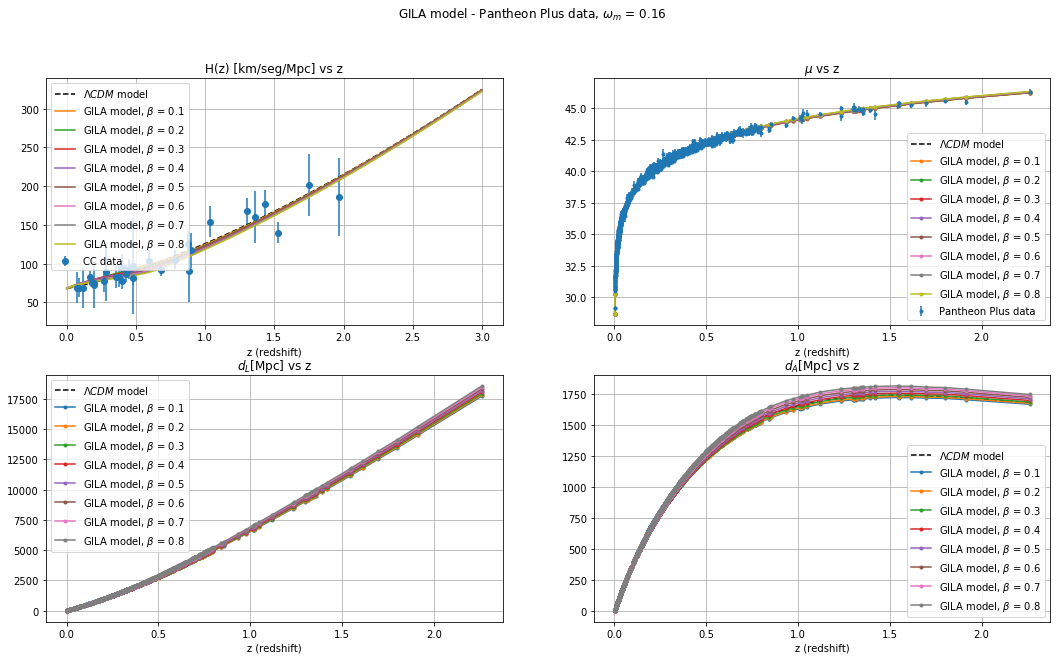

In [24]:
omega_m = 0.16

#LCDM stuff
h = H_0/100
Omega_m = omega_m/h**2

Hs_interpolado = interp1d(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_lcdm, Omega_m, H_0)**(-1), zs_lcdm, initial=0)
int_inv_Hs_interpolado = interp1d(zs_lcdm, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)

fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\omega_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \omega_m=0.16 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

#for beta in([0.1, 1., 6.145, 10, 100]):
#for beta in([1,2,3,4,5,6,7,8,9]):
#for beta in([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3]):
for beta in([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]):
    physical_params = [L_bar, beta, H_0, omega_m]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()


# $\omega_m = 0.17$

Given \omega_m=0.17 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 1759.9698102596196
For $\beta$ = 0.1, we have $\chi_2$ = 1716.8195206772443
For $\beta$ = 0.2, we have $\chi_2$ = 1728.6006855875307
For $\beta$ = 0.3, we have $\chi_2$ = 1734.5732576638106
For $\beta$ = 0.4, we have $\chi_2$ = 1727.1842458400738
For $\beta$ = 0.5, we have $\chi_2$ = 1714.7824024619792
For $\beta$ = 0.6, we have $\chi_2$ = 1706.6254197505866
For $\beta$ = 0.7, we have $\chi_2$ = 1709.1289651841253
For $\beta$ = 0.8, we have $\chi_2$ = 1725.3868164570276


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


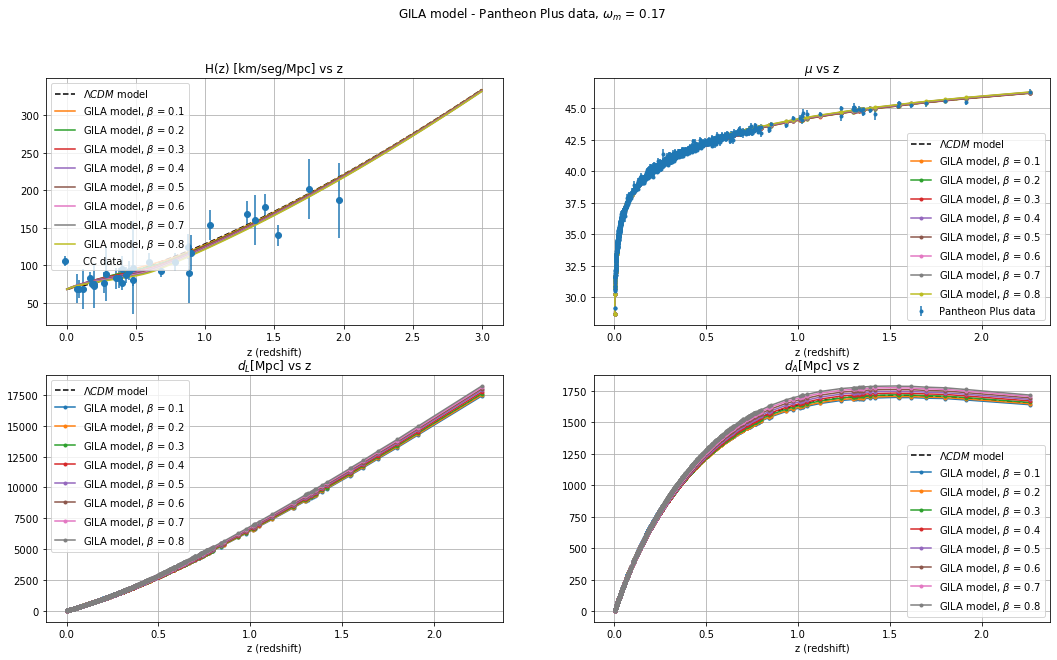

In [23]:
omega_m = 0.17

#LCDM stuff
h = H_0/100
Omega_m = omega_m/h**2

Hs_interpolado = interp1d(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_lcdm, Omega_m, H_0)**(-1), zs_lcdm, initial=0)
int_inv_Hs_interpolado = interp1d(zs_lcdm, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)

fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\omega_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \omega_m=0.17 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

#for beta in([0.1, 1., 6.145, 10, 100]):
#for beta in([1,2,3,4,5,6,7,8,9]):
#for beta in([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3]):
for beta in([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]):
    physical_params = [L_bar, beta, H_0, omega_m]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()


Given \omega_m=0.17 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 2139.478686121228
For $\beta$ = 0.1, we have $\chi_2$ = 2511.5125482679405
For $\beta$ = 1.0, we have $\chi_2$ = 1811.2651662393682
For $\beta$ = 6.145, we have $\chi_2$ = 2195.722117928713
For $\beta$ = 10, we have $\chi_2$ = 1936.4859193106245
For $\beta$ = 100, we have $\chi_2$ = 2139.702849642936


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


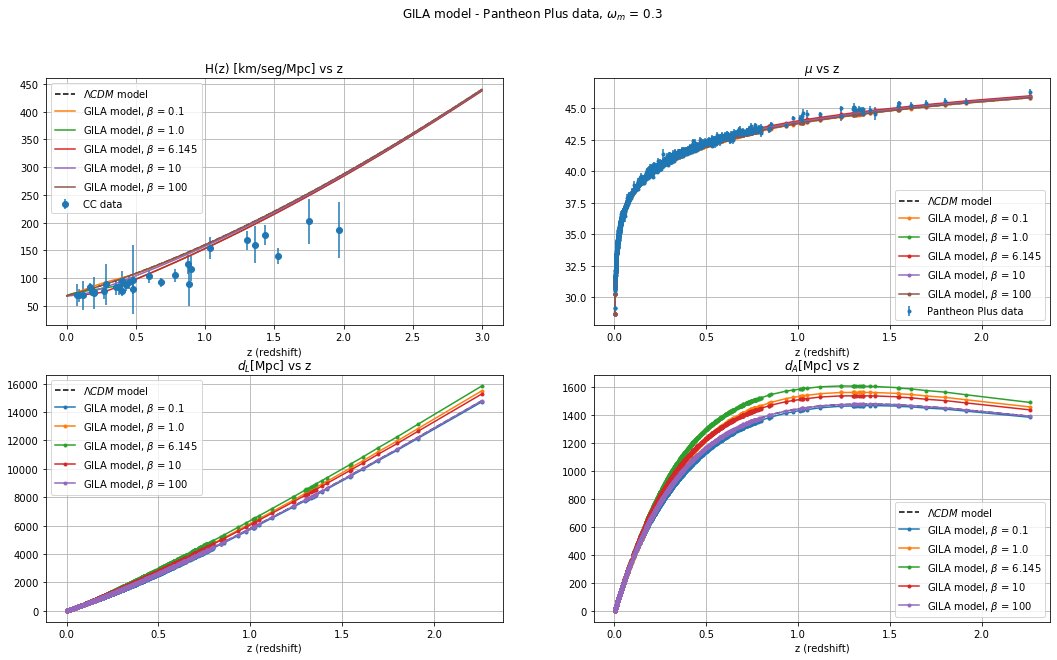

In [37]:
omega_m = 0.3

#LCDM stuff
h = H_0/100
Omega_m = omega_m/h**2

Hs_interpolado = interp1d(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_lcdm, Omega_m, H_0)**(-1), zs_lcdm, initial=0)
int_inv_Hs_interpolado = interp1d(zs_lcdm, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)

fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\omega_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_lcdm, H_LCDM(zs_lcdm, Omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \omega_m=0.17 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

for beta in([0.1, 1., 6.145, 10, 100]):
#for beta in([1,2,3,4,5,6,7,8,9]):
#for beta in([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3]):
#for beta in([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]):
    physical_params = [L_bar, beta, H_0, omega_m]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()
